# Antes de empezar

conda activate python3.6_cv2

In [1]:
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
import cv2
#from skimage import transform

import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline 

# Ignore harmless warnings:

from scipy import ndimage
import math
import random
import skimage
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [3]:
import platform
print(torch.__version__)
print(platform.python_version())
torch.cuda.get_device_name(1)

1.8.1
3.6.10


'TITAN X (Pascal)'

In [4]:
torch.cuda.current_device()

0

In [5]:
torch.cuda.device_count()

2

## Cargando datos

In [6]:
# Loading preprocessed images

import h5py
filename = "/home/abarreiro/data/handwriting/seq2seq/IAM_words_48_192.hdf5"

with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    data_header = list(f.keys())
    data = []
    
    for item in data_header:
        
        # Getting data:
        data.append(list(f[item]))
        
    # Creating dictionary between data names and data   
    new_dict = {name: obj for name, obj in zip(data_header, data)}


Keys: <KeysViewHDF5 ['X_trn', 'X_tst', 'X_val', 'filename_trn', 'filename_tst', 'filename_val', 'image_length_trn', 'image_length_tst', 'image_length_val', 'target_dict_keys', 'target_dict_values', 'target_length_trn', 'target_length_tst', 'target_length_val', 'target_trn', 'target_tst', 'target_val']>


## Definiendo diccionario, codificación y longitud máxima

In [7]:
# Dictionary used in seq2seq paper
decoder_dict = {0: '0', 1: '!', 2: 'L', 3: 'z', 4: 'G', 5: 'm', 6: '6', 7: '/', 8: 'j', 9: 's', 10: 'S', 11: '5',
                12: 'R', 13: ')', 14: 'u', 15: 'y', 16: '9', 17: 'g', 18: '3', 19: '1', 20: 'e', 21: "'", 22: ':',
                23: 'Q', 24: '2', 25: 'a', 26: 't', 27: 'A', 28: '7', 29: ';', 30: 'i', 31: 'H', 32: 'W', 33: ',',
                34: '(', 35: 'O', 36: 'U', 37: 'K', 38: 'd', 39: '*', 40: '.', 41: '?', 42: 'q', 43: '-', 44: 'r',
                45: 'n', 46: '&', 47: 'C', 48: '"', 49: 'h', 50: 'v', 51: 'f', 52: 'E', 53: 'p', 54: 'x', 55: '+',
                56: 'w', 57: 'b', 58: 'o', 59: ' ', 60: 'B', 61: 'P', 62: 'D', 63: 'I', 64: 'J', 65: 'V', 66: 'N',
                67: 'M', 68: '8', 69: 'k', 70: 'c', 71: '4', 72: 'T', 73: 'X', 74: 'l', 75: 'Z', 76: 'F', 77: 'Y',
                78: 'START', 79: 'END', 100: 'PAD'}

inverse_decoder_dict = {v: k for k, v in decoder_dict.items()}
print(inverse_decoder_dict['END'])

79


In [8]:
# One_hot_mapping assigns to each number in decoder_dict its corresponding one-hot vector:

one_hot_mapping = {}

cont = 0
for item in decoder_dict:
    vector = torch.zeros(1, 1, len(decoder_dict))
    vector[0, 0, cont] = 1.0
    one_hot_mapping[item] = vector
    cont += 1

# Inverse_one_hot_mapping assigns to each one-hot vector its corresponding number in decoder_dict
inverse_one_hot_mapping = {v: k for k, v in one_hot_mapping.items()}

# One_hot_to_char assigns to each possible one-hot vector its corresponding character from decoder_dict
one_hot_to_char = {}

for one_hot, char in zip(inverse_one_hot_mapping, inverse_decoder_dict):
    
    one_hot_to_char[one_hot] = char 
    
    
# Some examples...

print(one_hot_mapping[100])
print(inverse_one_hot_mapping[one_hot_mapping[100]])
print(one_hot_to_char[one_hot_mapping[100]])

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]])
100
PAD


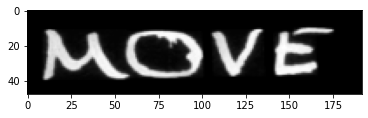

In [9]:
plt.imshow(new_dict['X_trn'][1], cmap='gray')

In [10]:
# All word vectors in 'target' are adjusted to max_length = 19:
a = [len(word) for word in new_dict['target_trn']]
max_length_trn = np.unique(a).item()
MAX_LENGTH = max(new_dict['target_length_trn'] + new_dict['target_length_val'] + new_dict['target_length_tst'])
print('Max length for the training set: ', max_length_trn, '|', 'Global max length: ', MAX_LENGTH)

Max length for the training set:  19 | Global max length:  19


In [11]:
def numpy_to_torch(array_list):
    tensor_list = []
    for array in array_list:
        tensor_list.append(torch.from_numpy(array))
        
    return tensor_list
    
a = numpy_to_torch(new_dict['target_trn'])
print(new_dict['target_trn'][0])
print(a[0])

#X_trn = numpy_to_torch(new_dict['X_trn'])
X_val = numpy_to_torch(new_dict['X_val'])
X_tst = numpy_to_torch(new_dict['X_tst'])
target_trn = numpy_to_torch(new_dict['target_trn'])
target_val = numpy_to_torch(new_dict['target_val'])
target_tst = numpy_to_torch(new_dict['target_tst'])

print(new_dict['target_tst'][0])
print(target_tst[0])

[ 27. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100.]
tensor([ 27., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100.], dtype=torch.float64)
[ 25.   9.   9.  14.  44.  20.  38.  45.  20.   9.   9. 100. 100. 100.
 100. 100. 100. 100. 100.]
tensor([ 25.,   9.,   9.,  14.,  44.,  20.,  38.,  45.,  20.,   9.,   9., 100.,
        100., 100., 100., 100., 100., 100., 100.], dtype=torch.float64)


# Definiendo funciones para el Data Augmentation

In [12]:
def get_bbox(img):
    
    height = img.shape[0]
    width = img.shape[1]
    a = np.where(img != 0) 
    bbox = img[np.min(a[0]):np.max(a[0])+1, np.min(a[1]):np.max(a[1])+1]
    
    x = np.min(a[1])
    w = np.max(a[1]) - np.min(a[1])
    y = np.min(a[0])
    h = np.max(a[0]) - np.min(a[0])
    
    bbox_params = [x, y, w, h]
    
    left_margin = x - 0
    right_margin = width - np.max(a[1])
    top_margin = y - 0
    bottom_margin = height - np.max(a[0])
    
    margin_sizes = [left_margin, right_margin, top_margin, bottom_margin]
    
    return bbox, bbox_params, margin_sizes 

In [13]:
def erosion(img, kernel_size):
    kernel = 255*np.ones((kernel_size, kernel_size), 'uint8')
    eroded = cv2.erode(img, kernel, iterations=1)
    maximum = eroded.max()
    if maximum > 0: # we need at least one non-zero pixel after erode
        eroded = eroded # otherwise, we won't be able to compute any bbox
        
    else:
        eroded = img
        
    return eroded

In [14]:
def dilation(img, margin_sizes, kernel_size):
    pixel_excess = math.ceil((kernel_size - 1)//2) # number of pixels that might overflow the image limits
    # after dilation
    condition = np.any(np.array(margin_sizes) < pixel_excess) # if we overflow the image limits
    if condition == True:
        dilated = img # we don't do anything
        
    else:
        kernel = 255*np.ones((kernel_size, kernel_size), 'uint8')
        dilated = cv2.dilate(img, kernel, iterations=1)
        
    return dilated

In [15]:
def rotation(img, angle):
    rotated = ndimage.rotate(img, angle, reshape=True)
    return rotated

In [16]:
def zoom_X(img, new_width):
    dsize = (new_width, img.shape[0])
    zoomed_X = cv2.resize(img, dsize, interpolation = cv2.INTER_AREA)
    return zoomed_X

In [17]:
def zoom_Y(img, new_height):
    dsize = (img.shape[1], new_height)
    zoomed_Y = cv2.resize(img, dsize, interpolation = cv2.INTER_AREA)
    return zoomed_Y

In [18]:
import math

def resize(new_img, src_img):
    
    height = src_img.shape[0]
    new_height = new_img.shape[0]
    width = src_img.shape[1] 
    new_width = new_img.shape[1]
    
    width_ratio = width/new_width
    height_resized = math.ceil(new_height*width_ratio)

    height_ratio = height/new_height
    width_resized = math.ceil(new_width*height_ratio)
    
    if new_width > width and new_height > height:
        
        if height_resized < height:
            
            dsize = (width, height_resized)
            img_rescaled = cv2.resize(new_img, dsize, interpolation = cv2.INTER_AREA)
            
        else:
            dsize = (width_resized, height)
            img_rescaled = cv2.resize(new_img, dsize, interpolation = cv2.INTER_AREA)
            
    elif new_width > width and new_height < height:
        
        dsize = (width, height_resized)
        img_rescaled = cv2.resize(new_img, dsize, interpolation = cv2.INTER_AREA)
        
    elif new_width < width and new_height > height:
        
        dsize = (width_resized, height)
        img_rescaled = cv2.resize(new_img, dsize, interpolation = cv2.INTER_AREA)
        
    else:
        
        img_rescaled = new_img
        
        
    return img_rescaled

In [19]:
def fitting(src_img, new_bbox, bbox, bbox_params, margin_sizes):
    
    height = src_img.shape[0]
    width = src_img.shape[1]
    x, y, w, h = bbox_params # parameters of the original bounding box to put top-left edge of the new_bbox
    # where the original was
    left_margin, right_margin, top_margin, bottom_margin = margin_sizes
    
    new_height = new_bbox.shape[0]
    new_width = new_bbox.shape[1]
    new_img = np.zeros(src_img.shape)
    
    fits_vertical = new_height + top_margin < height
    fits_horizont = new_width + left_margin < width

    if fits_vertical == False and fits_horizont == False:
        
        diff_vertical = (new_height + top_margin) - height
        diff_horizont = (new_width + left_margin) - width
        new_x = x - diff_horizont
        new_y = y - diff_vertical
        
        new_img[new_y:(new_y + new_height), new_x:(new_x + new_width)] = new_bbox
        
    elif fits_vertical == False and fits_horizont == True:
        
        diff_vertical = (new_height + top_margin) - height
        new_x = x
        new_y = y - diff_vertical
        new_img[new_y:(new_y + new_height), new_x:(new_x + new_width)] = new_bbox
        
    elif fits_vertical == True and fits_horizont == False:
        
        diff_horizont = (new_width + left_margin) - width
        new_x = x - diff_horizont
        new_y = y
        new_img[new_y:(new_y + new_height), new_x:(new_x + new_width)] = new_bbox
        
    else:
        new_x = x
        new_y = y
        new_img[new_y:(new_y + new_height), new_x:(new_x + new_width)] = new_bbox
        
    new_bbox_params = [new_x, new_y, new_width, new_height]
    
    return new_img, new_bbox_params

In [20]:
def displacement(new_img, new_bbox_params, d_x):
    # d_x has to be the amount of pixels
    new_x, new_y, new_width, new_height = new_bbox_params
    total_width = new_x + new_width + d_x
    if total_width > new_img.shape[1]:
        new_img_disp = new_img
        
    else:
        new_img_disp = new_img
        new_img_disp[:, d_x:] = new_img_disp[:, 0:-d_x]
        new_img_disp[:, 0:d_x] = 0
        
    return new_img_disp


In [21]:
def DataAugmentation(img):
    #img = img.numpy()
    bbox, bbox_params, margin_sizes = get_bbox(img)
    
    # Sequence of possible transformations:
    # Erosion/Dilation:
    p_er_dil = random.uniform(0,1)
    
    if p_er_dil < 0.33:
        kernel_size = random.randint(2,3)
        new_img = erosion(img, kernel_size)
        
    elif p_er_dil > 0.66:
        kernel_size = random.randint(2,5)
        new_img = dilation(img, margin_sizes, kernel_size)
        
    else:
        new_img = img
        
    updated_bbox, update_bbox_params, updated_margin_sizes = get_bbox(new_img)
    #Rotation:
    p_rot = random.uniform(0,1)
    if (p_rot < 0.2 and updated_bbox.max() > 0): # we need to rotate a non-zero matrix...
        angle = random.randint(-3,3)
        new_img = rotation(updated_bbox, angle)
        new_img, new_bbox_params, new_margin_sizes = get_bbox(new_img) # as we want a new bbox after rotation

    else:
        new_img = updated_bbox
        
    #Zoom in X axis:
    p_zoom_X = random.uniform(0,1)
    
    if p_zoom_X < 0.5:
        percentage_zoom_X = random.uniform(0.9,1.1)
        new_width = math.ceil(percentage_zoom_X*new_img.shape[1])
        new_img = zoom_X(new_img, new_width)
        
    else:
        new_img = new_img
        
    #Zoom in Y axis:
    p_zoom_Y = random.uniform(0,1)
    
    if p_zoom_Y < 0.5:
        percentage_zoom_Y = random.uniform(0.9,1.1)
        new_height = math.ceil(percentage_zoom_Y*new_img.shape[0])
        new_img = zoom_Y(new_img, new_height)
        
    else:
        new_img = new_img
    
    # Rescaling the new bbox in order to fit in the 48x192 original format:
    img_rescaled = resize(new_img, img)
    
    # Pasting the new bbox in the 48x192 image
    new_img, new_bbox_params = fitting(img, img_rescaled, bbox, bbox_params, margin_sizes)
    
    #Displacement:
    p_disp = random.uniform(0,1)
    
    if p_disp < 0.7:
        percentage_disp = random.uniform(0,0.1)
        d_x = math.ceil(percentage_disp*img.shape[1])
        new_img = displacement(new_img, new_bbox_params, d_x)
        
    else:
        new_img = new_img
        
    # Salt & Pepper noise:
    p_noise = random.uniform(0,1)
    if p_noise < 0.5:
        new_img = new_img/255
        new_img = skimage.util.random_noise(new_img, mode = 's&p')

    else:
        new_img = new_img/255
        
    new_img = torch.from_numpy(new_img)

    return new_img

In [22]:
'''a = X_trn[1]
b = DataAugmentation(a)
plt.imshow(b, cmap = 'gray')'''

"a = X_trn[1]\nb = DataAugmentation(a)\nplt.imshow(b, cmap = 'gray')"

In [23]:
torch.manual_seed(122344)
X_trn_data_aug = []
errors = []
for counter, image in enumerate(new_dict['X_trn']):
    try:
        image_da = DataAugmentation(image)
        X_trn_data_aug.append(image_da)
        
    except:
        errors.append(counter)
        X_trn_data_aug.append(torch.from_numpy(image))

In [24]:
'''
print(len(errors))
a = new_dict['X_trn'][errors[18]]
#b,c,d = get_bbox(a)
print(a.max())
plt.imshow(a)
print(errors[13]) #4915'''

"\nprint(len(errors))\na = new_dict['X_trn'][errors[18]]\n#b,c,d = get_bbox(a)\nprint(a.max())\nplt.imshow(a)\nprint(errors[13]) #4915"

In [25]:
#del X_trn

# Generando patches y etiquetas para muestra finita

In [26]:
def patch_gen_IAM(image, color_channels, height, width, patch_height, patch_width, stepsize):
    
    image = image / 255 # normalizing
        
    n_patches = int((width - patch_width)/stepsize + 1)
    patches_tensor = torch.empty(n_patches, color_channels, patch_height, patch_width)    
    
    start = 0
    
    for p in range(n_patches):
        
        patches_tensor[p, 0, :, :] = image[:, start:start + patch_width] # sliding window
        start += stepsize # updating the bottom-left position of the patch adding the stepsize
 
    return patches_tensor


def complete_set_IAM(image_set, target_set, color_channels, height, width, patch_height, patch_width, stepsize):
    
    complete_set = []
    set_range = len(target_set)
    
    for  i in range(set_range): 
        image_tensor = patch_gen_IAM(image_set[i], color_channels, height, width, patch_height, patch_width, stepsize)
        target_label = target_set[i]
        complete_set.append((image_tensor, target_label))
        
    return complete_set

In [27]:
comp_train_set = complete_set_IAM(X_trn_data_aug, target_trn, color_channels = 1, height = 48, width = 192,
                              patch_height = 48, patch_width = 10, stepsize = 2)
 
comp_val_set = complete_set_IAM(X_val, target_val, color_channels = 1, height = 48, width = 192,
                            patch_height = 48, patch_width = 10, stepsize = 2)

comp_test_set = complete_set_IAM(X_tst, target_tst, color_channels = 1, height = 48, width = 192, 
                             patch_height = 48, patch_width = 10, stepsize = 2)

#comp_test_set_2 = complete_set_IAM(test_set_2, color_channels = 1, height = 48, width = 192,
#                               patch_height = 48, patch_width = 10, stepsize = 2)

tensor(0.0039)
torch.Size([256, 92, 1, 48, 10])
torch.Size([23552, 1, 48, 10])
tensor([ 38.,  30.,   9.,  70.,  14.,   9.,   9., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100.], dtype=torch.float64)


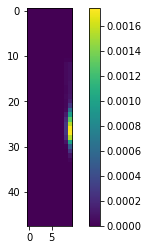

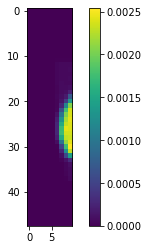

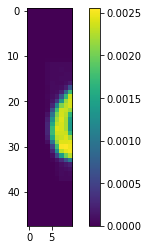

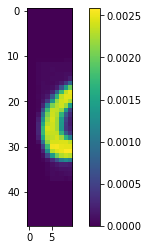

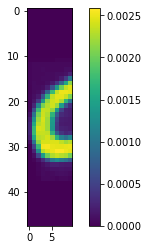

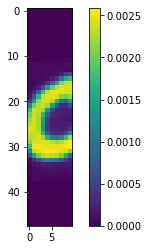

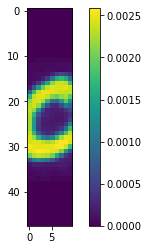

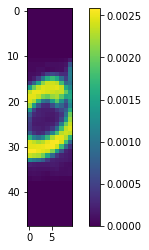

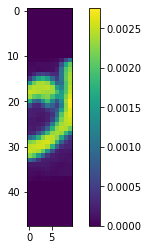

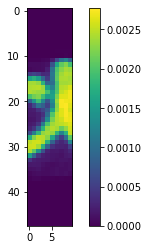

In [28]:
torch.manual_seed(1234)

train_loader = DataLoader(comp_train_set, batch_size = 256, shuffle = True, drop_last= True)
val_loader = DataLoader(comp_val_set, batch_size = 256, shuffle = False, drop_last= True)
test_loader = DataLoader(comp_test_set, batch_size = 256, shuffle = False, drop_last= True)
#test_2_loader = DataLoader(comp_test_set_2, batch_size = 16, shuffle = False, drop_last= True)

for image, label in train_loader:
    break
    
print(image[0].max())    
image_cnn = image.view(-1, 1, 48, 10)   
print(image.shape)
print(image_cnn.shape)
print(label[3])

for n_patch in range(0,10):
    patch = image[3,n_patch,0,:,:].cpu()
    plt.imshow(patch)
    plt.colorbar()
    plt.show()

In [29]:
def get_one_hot_target_IAM(labels, seq_len, output_size, batch_size):
    # labels: tensor containing the labels of the words in the batch
    # each word label consists of a vector of length 19 (MAX LENGTH). The 19 elements are the encoded characters of the word
    # (according to Jorge's decoder dict, and completed with PADs to reach length = 19)
    one_hot_target = torch.empty(batch_size, seq_len, output_size) # future one-hot encoding tensor for the words of the batch
    START = inverse_decoder_dict['START'] # code number of the START token (according to Jorge's decoder_dict)
    END = inverse_decoder_dict['END']
    PAD = inverse_decoder_dict['PAD']

    for j, word in enumerate(labels):
        
        It_has_PADs = torch.any(word == PAD).item() # (majority case: the label vector of the word is completed with PADs)
        one_hot_target[j, 0, :] = one_hot_mapping[START] # START token's one-hot vector goes first
        
        for k, letter in enumerate(word):
            one_hot_target[j, k + 1, :] = one_hot_mapping[letter.item()] # one-hot encoding of the rest of letters (including PADs)
            
        one_hot_target[j, -1, :] = one_hot_mapping[END] # last = END token
        
        if It_has_PADs == True: # if we had PADs
            
            array_of_PADs = torch.where(word == PAD)[0] 
            first_PAD = torch.min(array_of_PADs).item() # we store the first position where it appeared
            first_PAD = first_PAD + 1 # (recall that we added the START as first element, so the indices won't match)
            one_hot_target[j, first_PAD, :] = one_hot_mapping[END] # we replace that first PAD by an END
            one_hot_target[j, -1, :] = one_hot_mapping[PAD] # then the last element was a PAD, and not the END token
            
    return one_hot_target
                

In [30]:
END = inverse_decoder_dict['END']
print(one_hot_mapping[END])

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]]])


In [31]:
a = get_one_hot_target_IAM(target_tst[0:5], MAX_LENGTH + 2, len(decoder_dict), 5)
print(a.shape)

torch.Size([5, 21, 81])


In [32]:
def one_hot_conversion(decoder_output, output_size):
    
    one_hot_output_letter = torch.zeros(1, 1, output_size)
    index = torch.argmax(decoder_output, dim = 2).item()
    one_hot_output_letter[0, 0, index] = 1.
    
    return one_hot_output_letter

# Definiendo la arquitectura

In [33]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self, IN_CHANNELS, FILTERS_CNN_1, FILTERS_CNN_2, NEURONS_IN_DENSE_LAYER,
                 PATCH_HEIGHT, PATCH_WIDTH, STRIDE, PADDING, KERNEL_SIZE):
        super().__init__()
        self.IN_CHANNELS = IN_CHANNELS
        self.FILTERS_CNN_1 = FILTERS_CNN_1
        self.FILTERS_CNN_2 = FILTERS_CNN_2
        self.NEURONS_IN_DENSE_LAYER = NEURONS_IN_DENSE_LAYER
        self.PATCH_HEIGHT_AFTER_POOLING = PATCH_HEIGHT//4
        self.PATCH_WIDTH_AFTER_POOLING = PATCH_WIDTH//4
        self.STRIDE = STRIDE
        self.PADDING = PADDING
        self.KERNEL_SIZE = KERNEL_SIZE
        
        self.conv1 = nn.Conv2d(in_channels = self.IN_CHANNELS, out_channels = self.FILTERS_CNN_1,
                               kernel_size = self.KERNEL_SIZE, stride = self.STRIDE, padding = self.PADDING)
        self.conv2 = nn.Conv2d(in_channels = self.FILTERS_CNN_1, out_channels = self.FILTERS_CNN_2,
                               kernel_size = self.KERNEL_SIZE, stride = self.STRIDE, padding = self.PADDING)
        self.fc1 = nn.Linear(self.PATCH_HEIGHT_AFTER_POOLING * self.PATCH_WIDTH_AFTER_POOLING * self.FILTERS_CNN_2, 
                             self.NEURONS_IN_DENSE_LAYER)
        
    def forward(self, X):
        X = F.relu((self.conv1(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu((self.conv2(X)))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, self.PATCH_HEIGHT_AFTER_POOLING*self.PATCH_WIDTH_AFTER_POOLING*self.FILTERS_CNN_2)
        X = self.fc1(X)

        return X

In [34]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size, encoder_seq_len):        
        super(EncoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.seq_len = encoder_seq_len
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, batch_first = True)

    def forward(self, input, hidden):        
        output = input.view(self.batch_size, self.seq_len, self.input_size)
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, self.batch_size, self.hidden_size, device=device),
                torch.zeros(1, self.batch_size, self.hidden_size, device=device))

In [35]:
'''
class DecoderRNN(nn.Module):
    def __init__(self, output_size, hidden_size, batch_size, decoder_seq_len):
        super(DecoderRNN, self).__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.seq_len = decoder_seq_len

        self.lstm = nn.LSTM(self.output_size, self.hidden_size, batch_first = True)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim = 2)
        # dim = 2 porque esta última dimensión es la correspondiente a output_size, que es sobre
        # la que queremos hacer el softmax

    def forward(self, input, hidden):        
        output = input.view(self.batch_size, self.seq_len, self.output_size)
        #output = F.relu(output) # la relu se metía aquí porque en el
        #caso NLP del ejemplo de PyTorch previamente había una capa de embedding
        #No nos hace falta porque nuestro tensor de inputs ya es one-hot
        output, hidden = self.lstm(output, hidden)
        output = self.out(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, self.batch_size, self.hidden_size, device=device),
               torch.zeros(1, self.batch_size, self.hidden_size, device=device))'''

'\nclass DecoderRNN(nn.Module):\n    def __init__(self, output_size, hidden_size, batch_size, decoder_seq_len):\n        super(DecoderRNN, self).__init__()\n        self.output_size = output_size\n        self.hidden_size = hidden_size\n        self.seq_len = decoder_seq_len\n\n        self.lstm = nn.LSTM(self.output_size, self.hidden_size, batch_first = True)\n        self.out = nn.Linear(self.hidden_size, self.output_size)\n        self.softmax = nn.LogSoftmax(dim = 2)\n        # dim = 2 porque esta última dimensión es la correspondiente a output_size, que es sobre\n        # la que queremos hacer el softmax\n\n    def forward(self, input, hidden):        \n        output = input.view(self.batch_size, self.seq_len, self.output_size)\n        #output = F.relu(output) # la relu se metía aquí porque en el\n        #caso NLP del ejemplo de PyTorch previamente había una capa de embedding\n        #No nos hace falta porque nuestro tensor de inputs ya es one-hot\n        output, hidden = se

In [36]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p, batch_size, encoder_seq_len, decoder_seq_len):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.batch_size = batch_size
        self.encoder_seq_len = encoder_seq_len
        self.decoder_seq_len = decoder_seq_len
        
        self.attn = nn.Linear(self.output_size + self.hidden_size, self.encoder_seq_len)
        self.attn_combine = nn.Linear(self.output_size + self.hidden_size, self.output_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.output_size, self.hidden_size, batch_first = True)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, inputs, hidden, encoder_outputs):
        
        inputs = inputs.view(self.batch_size, self.decoder_seq_len, self.output_size)
        inputs = self.dropout(inputs)
        
        decoder_hidden_states = hidden[0].view(self.batch_size, self.decoder_seq_len, self.hidden_size) #[0] -- hidden, not cell
        
        attn_weights = F.softmax(
            self.attn(torch.cat((inputs, decoder_hidden_states), 2)), dim = 2)
        attn_applied = torch.bmm(attn_weights, encoder_outputs)

        output = torch.cat((inputs, attn_applied), 2)
        output = self.attn_combine(output)

        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)

        output = F.log_softmax(self.out(output), dim = 2)
        return output, hidden, attn_weights

    def initHidden(self):
        return (torch.zeros(1, self.batch_size, self.hidden_size, device=device),
               torch.zeros(1, self.batch_size, self.hidden_size, device=device))

In [37]:
'''
class BahdanauDecoder(nn.Module):
    def __init__(self, output_size, hidden_size, batch_size, n_patches, MAX_LENGTH, n_layers, drop_prob):
        super(BahdanauDecoder, self).__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.enc_seq_len = n_patches
        self.dec_seq_len = MAX_LENGTH + 2
        self.n_layers = n_layers
        self.drop_prob = drop_prob

        #self.embedding = nn.Embedding(self.output_size, self.hidden_size)

        self.fc_hidden = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.fc_encoder = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.weight = nn.Parameter(torch.FloatTensor(self.batch_size, self.hidden_size, self.dec_seq_len))
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.drop_prob)
        self.lstm = nn.LSTM(self.output_size + self.hidden_size, self.hidden_size, batch_first=True)
        self.classifier = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, inputs, hidden, encoder_outputs):
        #encoder_outputs = encoder_outputs.squeeze()
        # Embed input words
        #embedded = self.embedding(inputs).view(1, -1)
        inputs = self.dropout(inputs)
        output = inputs.view(self.batch_size, self.dec_seq_len, self.output_size)

        # Calculating Alignment Scores
        hidden_state = hidden[0].view(self.batch_size, n_layers, self.hidden_size) # hidden[0] --> picking h. state and not cell
        x = torch.tanh(self.fc_hidden(hidden_state) + self.fc_encoder(encoder_outputs)) # shape: [batch, seq_len, hidden_size]
        #alignment_scores = x.bmm(self.weight.unsqueeze(2))  
        alignment_scores = torch.bmm(x, self.weight) # shape: [batch, enc_seq, dec_seq]
        
        # Softmaxing alignment scores to get Attention weights
        #attn_weights = F.softmax(alignment_scores.view(1,-1), dim=1)
        
        attn_weights = F.softmax(alignment_scores, dim = 1)

        # Multiplying the Attention weights with encoder outputs to get the context vector
        #context_vector = torch.bmm(attn_weights.unsqueeze(0),
        #                         encoder_outputs.unsqueeze(0))
        context_vector = torch.bmm(attn_weights.view(self.batch_size, self.dec_seq_len, self.enc_seq_len), 
                                   encoder_outputs)
        
        
        # Concatenating context vector with embedded input word
        #output = torch.cat((embedded, context_vector[0]), 1).unsqueeze(0)
        
        output = torch.cat((output, context_vector), dim=2)
        
        # Passing the concatenated vector as input to the LSTM cell
        output, hidden = self.lstm(output, hidden)
        # Passing the LSTM output through a Linear layer acting as a classifier
        #output = F.log_softmax(self.classifier(output[0]), dim=1)
        
        output = F.log_softmax(self.classifier(output), dim = 2)
        
        return output, hidden, attn_weights'''

'\nclass BahdanauDecoder(nn.Module):\n    def __init__(self, output_size, hidden_size, batch_size, n_patches, MAX_LENGTH, n_layers, drop_prob):\n        super(BahdanauDecoder, self).__init__()\n        self.output_size = output_size\n        self.hidden_size = hidden_size\n        self.batch_size = batch_size\n        self.enc_seq_len = n_patches\n        self.dec_seq_len = MAX_LENGTH + 2\n        self.n_layers = n_layers\n        self.drop_prob = drop_prob\n\n        #self.embedding = nn.Embedding(self.output_size, self.hidden_size)\n\n        self.fc_hidden = nn.Linear(self.hidden_size, self.hidden_size, bias=False)\n        self.fc_encoder = nn.Linear(self.hidden_size, self.hidden_size, bias=False)\n        self.weight = nn.Parameter(torch.FloatTensor(self.batch_size, self.hidden_size, self.dec_seq_len))\n        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)\n        self.dropout = nn.Dropout(self.drop_prob)\n        self.lstm = nn.LSTM(self.output_size + sel

In [38]:
torch.manual_seed(1234)

CNN_model = ConvolutionalNetwork(IN_CHANNELS = 1, FILTERS_CNN_1 = 20, FILTERS_CNN_2 = 50, NEURONS_IN_DENSE_LAYER = 1024, 
                                 PATCH_HEIGHT = 48, PATCH_WIDTH = 10, STRIDE = 1, PADDING = 2, KERNEL_SIZE = 5).cuda(1)
CNN_optimizer = torch.optim.Adam(CNN_model.parameters())

Encoder_model = EncoderRNN(input_size = 1024, hidden_size = 256, batch_size = 256, encoder_seq_len = 92).cuda(1)
Encoder_optimizer = optim.SGD(Encoder_model.parameters(), lr = 0.001)

Decoder_model = AttnDecoderRNN(output_size = len(decoder_dict), hidden_size = 256, dropout_p = 0.1, batch_size = 256,
                               encoder_seq_len = 92, decoder_seq_len = 1).cuda(1)
Decoder_optimizer = optim.SGD(Decoder_model.parameters(), lr = 0.001)

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()

## Entrenando

In [39]:
import time

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [40]:
def calculate_loss(decoder_output, ground_truth, batch_size):
    loss = 0
        
    for j in range(batch_size):
        loss += criterion(decoder_output[j], ground_truth[j])               
    
    loss = loss/batch_size

    return loss

In [41]:
def train():
    train_losses = []
    for num_batch, (image, labels) in enumerate(train_loader):        
        num_batch += 1
        encoder_hidden = Encoder_model.initHidden()

        image_cnn = image.view(-1, 1, 48, 10).cuda(1)
        encoder_input = CNN_model(image_cnn)
        encoder_outputs, encoder_hidden = Encoder_model(encoder_input, encoder_hidden)
        
        
        decoder_hidden = encoder_hidden
        decoder_input = get_one_hot_target_IAM(labels=labels, seq_len = MAX_LENGTH + 2, output_size = len(decoder_dict), batch_size = 256).cuda(1)
        
        
        for num_letter in range(MAX_LENGTH + 2):
            
            decoder_input_letter = decoder_input[:, num_letter, :].unsqueeze(1)
            
            decoder_output, decoder_hidden, attn_weights = Decoder_model(decoder_input_letter, decoder_hidden, encoder_outputs)
            
            if num_letter == 0:
                
                decoder_output_total = decoder_output
                
            else:
                
                decoder_output_total = torch.cat((decoder_output_total, decoder_output), dim = 1)

        output_indices = torch.tensor(list(range(0, MAX_LENGTH + 2 -1))).cuda(1) # removing last token from the output
        decoder_output = torch.index_select(decoder_output_total, dim = 1, index = output_indices)

        ground_truth = torch.argmax(decoder_input, dim = 2)
        target_indices = torch.tensor(list(range(1, MAX_LENGTH + 2))).cuda(1) # remove SOS token from the input
        ground_truth = torch.index_select(ground_truth, dim = 1, index = target_indices)

        loss = calculate_loss(decoder_output, ground_truth, 16)

        CNN_optimizer.zero_grad()
        Encoder_optimizer.zero_grad()
        Decoder_optimizer.zero_grad()
        loss.backward()
        CNN_optimizer.step()
        Encoder_optimizer.step()
        Decoder_optimizer.step()
        train_losses.append(loss.item())
        
    return np.mean(train_losses)

In [42]:
def validation():
    valid_losses = []

    with torch.no_grad():       
        for num_batch_val, (image_val, labels_val) in enumerate(val_loader):        
            num_batch_val += 1
            encoder_hidden_val = Encoder_model.initHidden()
            image_cnn_val = image_val.view(-1, 1, 48, 10).cuda(1)
            encoder_input_val = CNN_model(image_cnn_val)
            encoder_outputs_val, encoder_hidden_val = Encoder_model(encoder_input_val, encoder_hidden_val)
        
            decoder_hidden_val = encoder_hidden_val
            decoder_input_val = get_one_hot_target_IAM(labels=labels_val, seq_len = MAX_LENGTH + 2, output_size = len(decoder_dict), batch_size = 256).cuda(1)
            
            
            for num_letter_val in range(MAX_LENGTH + 2):
            
                decoder_input_letter_val = decoder_input_val[:, num_letter_val, :].unsqueeze(1)

                decoder_output_val, decoder_hidden_val, attn_weights_val = Decoder_model(decoder_input_letter_val, decoder_hidden_val, encoder_outputs_val)

                if num_letter_val == 0:

                    decoder_output_total_val = decoder_output_val

                else:

                    decoder_output_total_val = torch.cat((decoder_output_total_val, decoder_output_val), dim = 1)

            
            output_indices_val = torch.tensor(list(range(0, MAX_LENGTH + 2 - 1))).cuda(1) # remove last token from the output
            decoder_output_val = torch.index_select(decoder_output_total_val, dim = 1, index = output_indices_val)

            ground_truth_val = torch.argmax(decoder_input_val, dim = 2)
            target_indices_val = torch.tensor(list(range(1, MAX_LENGTH + 2))).cuda(1) # remove START token from the input
            ground_truth_val = torch.index_select(ground_truth_val, dim = 1, index = target_indices_val)
            
            loss_val = calculate_loss(decoder_output_val, ground_truth_val, 16)
            valid_losses.append(loss_val.item())
    return np.mean(valid_losses)

In [43]:
class Patience():
    
    def __init__(self, patience):
        self.patience = patience
        self.current_patience = patience
        self.min_loss_val = float('inf')

    def more_patience(self,loss_val):
        self.current_patience -= 1
        if self.current_patience == 0:
            return False

        if loss_val < self.min_loss_val:
            self.min_loss_val = loss_val
            self.current_patience = patience

            model_name = f"IAM_Data_Aug_{48}x{192}_by{10}_jump{2}_batch{256} NN1_{20}_NN2_{50}_{1024}_{5}_{256} pats:{47926}"
            print(", saved best model.")
            
            torch.save({
                'CNN_model_state_dict_IAM_Data_Aug': CNN_model.state_dict(),
                'CNN_optimizer_state_dict_IAM_Data_Aug': CNN_optimizer.state_dict(),
                'Encoder_model_state_dict_IAM_Data_Aug': Encoder_model.state_dict(),
                'Encoder_optimizer_state_dict_IAM_Data_Aug': Encoder_optimizer.state_dict(),
                'Decoder_model_state_dict_IAM_Data_Aug': Decoder_model.state_dict(),
                'Decoder_optimizer_state_dict_IAM_Data_Aug': Decoder_optimizer.state_dict(),
            }, 'Attention_IAM_Data_Aug'+model_name)
            
            torch.save(CNN_model.state_dict(), 'CNN_'+model_name)
            torch.save(Encoder_model.state_dict(), 'Encoder_'+model_name)
            torch.save(Decoder_model.state_dict(), 'Decoder_'+model_name)
    
        return True

In [ ]:
torch.manual_seed(1234)
patience = 2000

patience_controler = Patience(patience)
start_time = time.time()

for num_epoch in range(5000000):
    train_loss = train()        
    valid_loss = validation()
    
    writer.add_scalar('Loss/train', train_loss, num_epoch)
    writer.add_scalar('Loss/validation', valid_loss, num_epoch)
    
    print(f'Epoch: {num_epoch} Train loss: {train_loss} Valid loss: {valid_loss} Duration: {(time.time() - start_time)/60} minutes',)

    if not patience_controler.more_patience(valid_loss):
        print("Se acabó la paciencia")
        break

        


Epoch: 0 Train loss: 3.496923375257196 Valid loss: 2.736971107022516 Duration: 0.9023597915967305 minutes
, saved best model.
Epoch: 1 Train loss: 1.9824378394825573 Valid loss: 1.4012276879672347 Duration: 1.8040836135546365 minutes
, saved best model.
Epoch: 2 Train loss: 1.3968449735386486 Valid loss: 1.220095527583155 Duration: 2.7112894892692565 minutes
, saved best model.
Epoch: 3 Train loss: 1.2581817306936744 Valid loss: 1.132389393346063 Duration: 3.628182641665141 minutes
, saved best model.
Epoch: 4 Train loss: 1.1943658472382448 Valid loss: 1.092471552306208 Duration: 4.55225316286087 minutes
, saved best model.
Epoch: 5 Train loss: 1.1523118701210633 Valid loss: 1.0598726909736107 Duration: 5.487019193172455 minutes
, saved best model.
Epoch: 6 Train loss: 1.1250956303933088 Valid loss: 1.0200779910745292 Duration: 6.425353153546651 minutes
, saved best model.
Epoch: 7 Train loss: 1.1014211267073524 Valid loss: 1.0008414243829662 Duration: 7.356888878345489 minutes
, saved

# IGNORE CELLS BELOW (THEY'RE NOT THE PROPER TEST)

## Cargar modelo

In [ ]:
CNN_model.load_state_dict(torch.load('CNN_model_30000_words_TF_PAD_noise.pt'))
CNN_model.eval()

Encoder_model.load_state_dict(torch.load('Encoder_model_30000_words_TF_PAD_noise.pt'))
Encoder_model.eval()

Decoder_model.load_state_dict(torch.load('Decoder_model_30000_words_TF_PAD_noise.pt'))
Decoder_model.eval()

In [ ]:
def Test():
    with torch.no_grad():
        for num_batch, (image_test, label_test) in enumerate(test_loader):
            num_batch += 1
            encoder_hidden_test = Encoder_model.initHidden(batch_size = batch_size)
            image_cnn_test = image_test.view(-1, color_channels, patch_height, patch_width).cuda(1)
            encoder_input_test = CNN_model(image_cnn_test)
            encoder_output, encoder_hidden_test = Encoder_model(encoder_input_test, encoder_hidden_test, batch = test_batch, seq_len = n_patches)

            #decoder_hidden_test = (encoder_hidden_test[0][0, :, :].view(1, batch_size, hidden_size), # We take the last hidden state of the Encoder 
            #                       encoder_hidden_test[1][0, :, :].view(1, batch_size, hidden_size)) # for each image/word (j) within the batch 
            
            for j in range(batch_size):
                decoder_input_test = mapeo['START'].cuda(1) # We initialize the first Decoder input as the START token
                decoder_hidden_test = (encoder_hidden_test[0][0, j, :].view(1, 1, hidden_size), # We take the last hidden state of the Encoder 
                                       encoder_hidden_test[1][0, j, :].view(1, 1, hidden_size)) # for each image/word (j) within the batch 
                
                for d in range(MAX_LENGTH + 2):
                    decoder_output_test, decoder_hidden_test = Decoder_model(decoder_input_test, decoder_hidden_test, batch = 1, seq_len = 1)

                    output_letter = one_hot_conversion(decoder_output_test, output_size = output_size)
                    decoder_input_test = output_letter
                    
                    if d == 0:
                        output_word = output_letter
                    else:
                        output_word = torch.cat((output_word, output_letter), dim = 1).cuda(1)
                    
                    if torch.equal(output_letter, letter_to_vector('END').cuda(1)):
                        break
                output_word = torch.argmax(output_word, dim=2)
                output_word = output_word.view(output_word.numel()) # view as a rank-1 tensor

                model_word = []
                for item in output_word:
                    model_word.append(letters[item])

                model_word = ''.join(model_word[:-1])
                print(model_word)
            print(test_set) 


In [ ]:
Test()

In [ ]:
# activar pytorch_estoril (environment) en la terminal y ejecutar tensorboard --host 0.0.0.0 --logdir ./runs
# Tensorboard se ejecutará en un cierto puerto y nos dará el enlace. Habrá que sustituir la IP 0.0.0.0 por la del equipo
# en remoto en la que esté corriendo en el caso de Estoril 212.128.3.86: